In [2]:
import pyspark
sc = pyspark.SparkContext(appName="Spark Donald Trump Communication Analysis on Twitter")

In [198]:
df = spark.read.text('trump_tweets.txt')

In [199]:
df.printSchema()
df.show()

root
 |-- value: string (nullable = true)

+--------------------+
|               value|
+--------------------+
|Republicans and D...|
|I was thrilled to...|
|RT @CBS_Herridge:...|
|The Unsolicited M...|
|RT @MZHemingway: ...|
|RT @WhiteHouse: P...|
|“I’m running as a...|
|Getting a little ...|
|https://t.co/4qwC...|
|https://t.co/VlEu...|
|https://t.co/z5CR...|
|https://t.co/TQCQ...|
|RT @EricTrump: ht...|
|"RT @GOPChairwoma...|
|                    |
|273K jobs added i...|
|                    |
|7M+ jobs added si...|
|                    |
|Unemploym…";08/03...|
+--------------------+
only showing top 20 rows



In [56]:
# first read the trump_tweets.txt file into the RDD rdd_mbox

rdd_tweets = sc.textFile('trump_tweets.txt')

# print a sample of 10 lines of rdd_mox

rdd_tweets.take(10)

['Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50',
 'RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those 

In [83]:
# we define an utility function that can split each line into individual words by using multiple separators
# this function returns a list of individual words from the string parameter by applying the split
# note that the result can contain empty strings

import re
def split_with_multiple_separator(string_value): return re.split('#|,| |[|]|.;', string_value.strip())

#usage example:

split_with_multiple_separator(rdd_tweets.take(1)[0])

['Republicans',
 'and',
 'Democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems',
 '02/08/2011',
 '18:07:48']

In [93]:
# compute an rdd with individual words (rdd_tweets_words) from the rdd_product by using the previous function
# rdd_tweets_words should not contain empty strings


rdd_tweets_words = rdd_tweets.flatMap(split_with_multiple_separator).filter(lambda word: word!='')
rdd_tweets_words.take(60)

['Republicans',
 'and',
 'Democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems',
 '02/08/2011',
 '18:07:48',
 'I',
 'was',
 'thrilled',
 'to',
 'be',
 'back',
 'in',
 'the',
 'Great',
 'city',
 'of',
 'Charlotte',
 'North',
 'Carolina',
 'with',
 'thousands',
 'of',
 'hardworking',
 'American',
 'Patriots',
 'who',
 'love',
 'our',
 'Country',
 'cherish',
 'our',
 'values',
 'respect',
 'our',
 'laws',
 'and',
 'always',
 'put',
 'AMERICA',
 'FIRST!',
 'Thank',
 'you',
 'for',
 'a',
 'wonderful',
 'evening!!',
 'KAG2020',
 'https://t.co/dNJZfRsl9',
 '03/03/2020',
 '01:34:50',
 'RT',
 '@CBS_Herridge:',
 'READ:',
 'Letter']

In [90]:
#Create a function to delete "https"

delsite = ["https"]
def delhttps(line):
    for i in delsite:
        if i in line:
            return 1
    return 0


In [95]:
rdd_tweets_words = rdd_tweets_words.filter(lambda line: delhttps(line) != 1)
rdd_tweets_words.take(60)

['Republicans',
 'and',
 'Democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems',
 '02/08/2011',
 '18:07:48',
 'I',
 'was',
 'thrilled',
 'to',
 'be',
 'back',
 'in',
 'the',
 'Great',
 'city',
 'of',
 'Charlotte',
 'North',
 'Carolina',
 'with',
 'thousands',
 'of',
 'hardworking',
 'American',
 'Patriots',
 'who',
 'love',
 'our',
 'Country',
 'cherish',
 'our',
 'values',
 'respect',
 'our',
 'laws',
 'and',
 'always',
 'put',
 'AMERICA',
 'FIRST!',
 'Thank',
 'you',
 'for',
 'a',
 'wonderful',
 'evening!!',
 'KAG2020',
 '03/03/2020',
 '01:34:50',
 'RT',
 '@CBS_Herridge:',
 'READ:',
 'Letter',
 'to']

In [110]:
# split each tweet into words
words = rdd_tweets.flatMap(lambda line: line.split(" "))

# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags = words.filter(lambda w: '#' in w).map(lambda x: (x, 1))
hashtags.take(10)

[('#KAG2020', 1),
 ('#MAGA', 1),
 ('#VOTE', 1),
 ('#MAGA🇺🇸🦅rally', 1),
 ('#VOTE', 1),
 ('#2A,', 1),
 ('#VOTE', 1),
 ('#MAGA', 1),
 ('"#VoteEarlyDay', 1),
 ('#MAGA🇺🇸', 1)]

In [111]:
hashtags_count = hashtags.reduceByKey(lambda x,y : x+y).sortBy(lambda tuple: tuple[1], ascending=False)
hashtags_count.take(10)

[('#Trump2016', 395),
 ('#MAGA', 340),
 ('#MakeAmericaGreatAgain', 258),
 ('#1', 108),
 ('#CelebApprentice', 95),
 ('#CelebrityApprentice', 83),
 ('#KAG2020', 61),
 ('#AmericaFirst', 61),
 ('#Trump2016""""', 59),
 ('#Trump', 57)]

In [112]:
# filter the words to get only references, then map each reference to be a pair of (reference,1)
references = words.filter(lambda w: '@' in w).map(lambda x: (x, 1))
references.take(10)

[('@CBS_Herridge:', 1),
 ('@MZHemingway:', 1),
 ('@WhiteHouse:', 1),
 ('@realDonaldTrump', 1),
 ('@EricTrump:', 1),
 ('@GOPChairwoman:', 1),
 ('@realDonaldTrump', 1),
 ('@TomFitton:', 1),
 ('@RealDonaldTrump', 1),
 ('@marklevinshow:', 1)]

In [113]:
references_count = references.reduceByKey(lambda x,y : x+y).sortBy(lambda tuple: tuple[1], ascending=False)
references_count.take(10)

[('@realDonaldTrump', 8553),
 ('@realDonaldTrump:', 1087),
 ('@WhiteHouse:', 658),
 ('@FoxNews', 519),
 ('@BarackObama', 474),
 ('@foxandfriends', 449),
 ('@ApprenticeNBC', 296),
 ('@CNN', 276),
 ('@TeamTrump:', 276),
 ('@GOPChairwoman:', 212)]

In [114]:
#Apply a function called “Func” to lower the case of each word 
def Func(lines):
      lines = lines.lower()
      lines = lines.split()
      return lines
rdd_tweets_words_lower = rdd_tweets_words.flatMap(Func)
rdd_tweets_words_lower.take(10)

['republicans',
 'and',
 'democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems',
 '02/08/2011']

In [115]:
# initialize an rdd with key/value for counting each word in the file 

rdd_tweets_words_kv = rdd_tweets_words_lower.map(lambda word: (word, 1))

rdd_tweets_words_kv.take(10)

[('republicans', 1),
 ('and', 1),
 ('democrats', 1),
 ('have', 1),
 ('both', 1),
 ('created', 1),
 ('our', 1),
 ('economic', 1),
 ('problems', 1),
 ('02/08/2011', 1)]

In [116]:
# we read the positive words

rdd_positive_words = sc.textFile('positive-words.txt')

rdd_positive_words.take(5)

['a+', 'abound', 'abounds', 'abundance', 'abundant']

In [117]:
# initialize an rdd with key/value for counting each positive word in the file 


rdd_positive_words_kv = rdd_positive_words.map(lambda word: (word, 1))

rdd_positive_words_kv.take(5)

[('a+', 1), ('abound', 1), ('abounds', 1), ('abundance', 1), ('abundant', 1)]

In [118]:
# rdd_positive_words_tweets_kv RDD should contain positive words in the product review file

rdd_positive_words_tweets_kv = rdd_tweets_words_kv.join(rdd_positive_words_kv)

rdd_positive_words_tweets_kv.take(5)

[('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1))]

In [119]:
# use the mapValues transformation to assign a default count of 1 for each positive word

rdd_positive_words_tweets_kv = rdd_positive_words_tweets_kv.mapValues(lambda tuple: 1)

rdd_positive_words_tweets_kv.take(5)

[('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1)]

In [120]:
# rdd_positive_words_tweets_count_kv should contain the number of occurences (count) of each positive word in tweets

rdd_positive_words_tweets_count_kv = rdd_positive_words_tweets_kv.reduceByKey(lambda x,y : x+y)


rdd_positive_words_tweets_count_kv.take(5)

[('thrilled', 48),
 ('wonderful', 470),
 ('right', 753),
 ('sustainable', 1),
 ('best', 1130)]

In [121]:
# rdd_positive_words_tweets_count_kv_ordered should contain the previous RDD in descending order based on the count

rdd_positive_words_tweets_count_kv_ordered = rdd_positive_words_tweets_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_positives_opinion = rdd_positive_words_tweets_count_kv_ordered.take(25)

list_top_positives_opinion

[('great', 6898),
 ('trump', 4845),
 ('thank', 3443),
 ('like', 1977),
 ('good', 1669),
 ('best', 1130),
 ('love', 1122),
 ('win', 866),
 ('work', 856),
 ('right', 753),
 ('better', 750),
 ('strong', 692),
 ('well', 609),
 ('support', 564),
 ('congratulations', 561),
 ('happy', 551),
 ('amazing', 504),
 ('wonderful', 470),
 ('nice', 450),
 ('honor', 436),
 ('beautiful', 394),
 ('important', 393),
 ('fantastic', 364),
 ('enjoy', 362),
 ('incredible', 360)]

In [122]:
rdd_negative_words = sc.textFile('negative-words.txt')

rdd_negative_words.take(5)

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']

In [123]:
# initialize an rdd with key/value for counting each negative word in the file 

rdd_negative_words_kv = rdd_negative_words.map(lambda word: (word, 1))

rdd_negative_words_kv.take(5)

[('2-faced', 1),
 ('2-faces', 1),
 ('abnormal', 1),
 ('abolish', 1),
 ('abominable', 1)]

In [124]:
# rdd_negative_words_tweets_kv RDD should contain negative words in the tweets file

rdd_negative_words_tweets_kv = rdd_tweets_words_kv.join(rdd_negative_words_kv)

rdd_negative_words_tweets_kv.take(5)

[('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1))]

In [125]:
# use the mapValues transformation to assign a default count of 1 for each negative word

rdd_negative_words_tweets_kv = rdd_negative_words_tweets_kv.mapValues(lambda tuple:1)

rdd_negative_words_tweets_kv.take(5)

[('threat', 1), ('threat', 1), ('threat', 1), ('threat', 1), ('threat', 1)]

In [126]:
# rdd_negative_words_tweets_count_kv should contain the number of occurences (count) of each negative word in tweets

rdd_negative_words_tweets_count_kv = rdd_negative_words_tweets_kv.reduceByKey(lambda x,y: x+y)

rdd_negative_words_tweets_count_kv.take(5)

[('threat', 76),
 ('fraud', 154),
 ('dishonest', 187),
 ('lost', 336),
 ('killed', 163)]

In [127]:
# rdd_negative_words_tweets_count_kv_ordered should contain the previous RDD in descending order based on the count

rdd_negative_words_tweets_count_kv_ordered = rdd_negative_words_tweets_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_negatives_opinion = rdd_negative_words_tweets_count_kv_ordered.take(25)

list_top_negatives_opinion

[('fake', 1195),
 ('bad', 899),
 ('hard', 690),
 ('crime', 485),
 ('crooked', 435),
 ('illegal', 391),
 ('radical', 382),
 ('lost', 336),
 ('terrible', 325),
 ('corrupt', 324),
 ('wrong', 312),
 ('collusion', 296),
 ('sad', 273),
 ('miss', 270),
 ('attack', 257),
 ('failing', 250),
 ('failed', 247),
 ('worst', 245),
 ('crazy', 238),
 ('problem', 226),
 ('phony', 224),
 ('disaster', 217),
 ('weak', 215),
 ('badly', 210),
 ('hoax', 209)]

In [128]:
# the utility function plot_opinion plots a bar chart presenting top positives and top negatives words
# the parameters are list of tuples containing counts from positives and negatives words

from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd

def plot_opinion(list_positives, list_negatives):
    
    list_1 = [(t[0], t[1], 'positive') for t in list_positives]
    list_2 = [(t[0], t[1], 'negative') for t in list_negatives]
    
     
    list_1.extend(list_2)
    
    
    pd_df = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],
     'polarity': [ t[2] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    pd_df['color'] = pd_df.polarity.apply(lambda polarity: 'green' if polarity=='positive' else 'red')
    
    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='Opinion', y='Count', hue='polarity', palette=["green", "red"], order=pd_df['Opinion'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), pd_df['color']): 
        tick.set_color(color)
    
    plt.show()

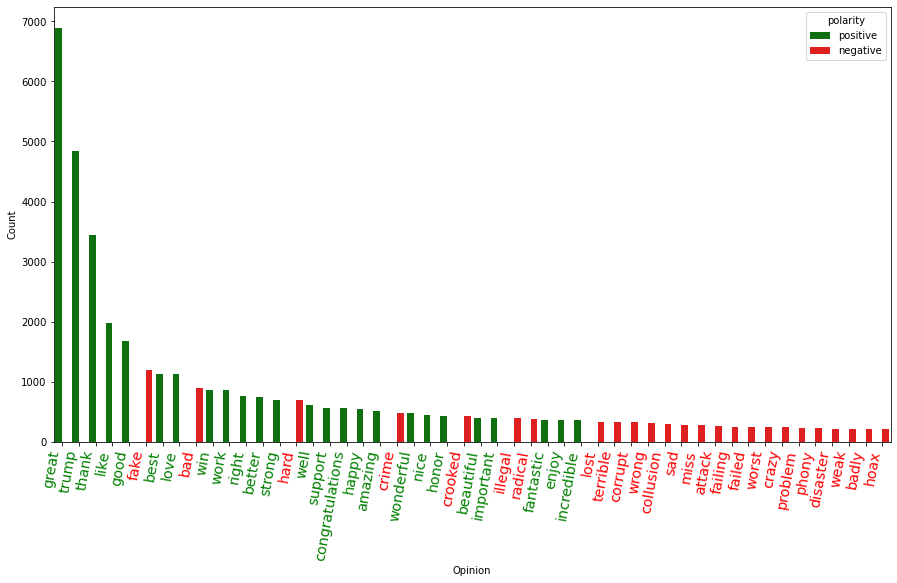

In [129]:
# call the plot_opinion function to plot tweets top positives and negatives words

plot_opinion(list_top_positives_opinion, list_top_negatives_opinion)

In [172]:
# we read our stop words
#add some stop words: @realdonaldtrump; @realdonaldtrump:; &amp; donald; don’t
rdd_stop_words = sc.textFile('stop-words.txt')

rdd_stop_words.take(5)

['a', 'about', 'above', 'across', 'after']

In [131]:
# compute the neutral/contextual words RDD by using rdd_product_words, rdd_positive_words, rdd_negative_words and rdd_stop_words
# neutral words are words in product reviews file, that are not positive words or negative words or stop words
# tip: you can use the subtract transformation on RDD see documentation 
# http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD

contextual_words = rdd_tweets_words_lower.subtract(rdd_positive_words).subtract(rdd_negative_words).subtract(rdd_stop_words)

contextual_words.take(20)

['action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action']

In [132]:
# use multiple transformations for counting each contextual word in the product review file, sorted in ascending order based 
# on the count

contextual_words_count_ordered = contextual_words.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_contextual_words = contextual_words_count_ordered.take(50)  

list_top_contextual_words

[('rt', 7902),
 ('president', 3619),
 ('just', 3239),
 ('people', 2953),
 ('new', 2432),
 ('big', 1881),
 ('america', 1808),
 ('make', 1804),
 ('country', 1690),
 ('time', 1597),
 ('"rt', 1579),
 ('democrats', 1568),
 ('obama', 1495),
 ('news', 1486),
 ('going', 1474),
 ('want', 1375),
 ('vote', 1373),
 ('american', 1367),
 ('thanks', 1299),
 ('need', 1172),
 ('today', 1168),
 ('u.s.', 1149),
 ('think', 1086),
 ('doing', 1081),
 ('run', 1072),
 ('really', 1069),
 ('job', 1044),
 ('did', 1030),
 ('media', 1013),
 ('know', 999),
 ('years', 976),
 ('china', 957),
 ('said', 951),
 ('way', 925),
 ('house', 871),
 ("don't", 871),
 ('day', 868),
 ('jobs', 858),
 ('united', 857),
 ('state', 840),
 ('biden', 839),
 ('got', 827),
 ('hillary', 821),
 ('states', 816),
 ('total', 808),
 ('look', 787),
 ('border', 786),
 ('national', 773),
 ('don’t', 754),
 ('joe', 749)]

In [133]:
# the utility function plot_contextual_words plots a bar chart presenting top contextual words
# the parameter are list of tuples containing counts from contextual words

def plot_contextual_words(list_contextual_words):
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='blue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

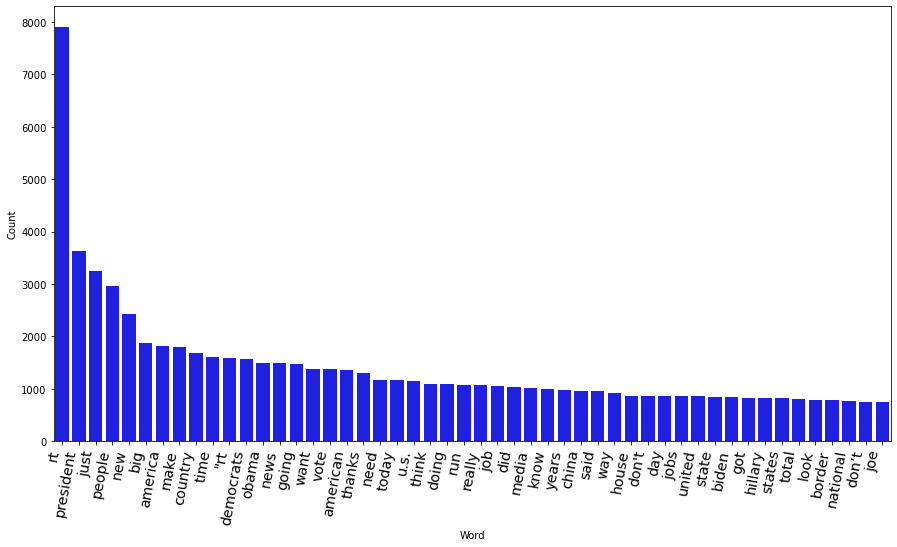

In [134]:
# call the plot_contextual_words function to plot tweets top contextual words

plot_contextual_words(list_top_contextual_words)

In [135]:
# Compute the global sentiment score: the total count of positive words (e.g. use rdd_positive_words_product_count_kv) minus
# the total count of negative words (e.g. use rdd_negative_words_product_count_kv)


sentiment_score = rdd_positive_words_tweets_count_kv.map(lambda tuple: tuple[1]).sum()\
                  - rdd_negative_words_tweets_count_kv.map(lambda tuple: tuple[1]).sum()

print('The sentiment score is : ',sentiment_score)

The sentiment score is :  22680


In [183]:
#You can explore all these points over the time (per month or per year for instance), 
#and make a differentiation between original tweets and retweets (RT).


#original tweets
rdd_original_tweets  = rdd_tweets.filter(lambda line: "RT" not in line)
rdd_original_tweets.take(10)

['Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58',
 '“I’m running as a proud Democrat, for the Senate”. Sleepy Joe Biden today. It’s only going to get worse. It is not sustainable for our County - China will own us!!!!;12/10/2020 22:22:39',
 'Getting a little exercise this morning! https://t.co/fyAAcbhbgk;01/02/2020 16:14:02',
 'https://t.

In [190]:
#Number of original tweets

rdd_original_tweets.count()

48618

In [189]:
#Retweets

rdd_retweets = rdd_tweets.filter(lambda line: "RT" in line)
rdd_retweets.take(10)


['RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those articles and tho…;17/01/2020 13:13:59",
 'RT @WhiteHouse: President @realDonaldTrump announced historic steps to protect the Constitutional right to pray in public schools! https://…;17/01/2020 00:11:56',
 'RT @EricTrump: https://t.co/NcrNdOSfIV;23/10/2020 04:30:19',
 '"RT @GOPChairwoman: The economic boom continues!',
 "RT @TomFitton: Vindman's behavior is a scandal. He should be removed from the @RealDonaldTrump White House ASAP to protect our foreign poli…;07/02/2020 17:35:20",
 "RT @marklevinshow: President Trump was outstanding.\xa0 I couldn't be prouder.\xa0 Biden was making faces and was very dishonest about some of hi…;23/10/2020 03:58:38",
 'RT @RealRLimbaugh: Winning, winning, winning! @real

In [188]:
#Number of retweets

rdd_retweets.count()

10063

Comparison between original tweets and retweets

In [97]:
### Analysis of original tweets


# split each tweet into words
words_ot = rdd_original_tweets.flatMap(lambda line: line.split(" "))

# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags_ot = words_ot.filter(lambda w: '#' in w).map(lambda x: (x, 1))
hashtags_ot.take(10)

[('#KAG2020', 1),
 ('#MAGA', 1),
 ('#VOTE', 1),
 ('#VOTE', 1),
 ('#2A,', 1),
 ('#VOTE', 1),
 ('#MAGA', 1),
 ('"#VoteEarlyDay', 1),
 ('#MAGA🇺🇸', 1),
 ('#MAGA', 1)]

In [98]:
hashtags_ot_count = hashtags_ot.reduceByKey(lambda x,y : x+y).sortBy(lambda tuple: tuple[1], ascending=False)
hashtags_ot_count.take(10)

[('#Trump2016', 382),
 ('#MAGA', 280),
 ('#MakeAmericaGreatAgain', 245),
 ('#1', 102),
 ('#CelebApprentice', 95),
 ('#CelebrityApprentice', 83),
 ('#Trump2016""""', 59),
 ('#KAG2020', 53),
 ('#VoteTrump', 53),
 ('#AmericaFirst', 52)]

In [99]:
# filter the words to get only references, then map each reference to be a pair of (reference,1)
references_ot = words_ot.filter(lambda w: '@' in w).map(lambda x: (x, 1))
references_ot.take(10)

[('@realDonaldTrump', 1),
 ('@JoeBiden...', 1),
 ('@JesseBWatters', 1),
 ('@realDona…";25/10/2020', 1),
 ('@POTUS', 1),
 ('@JohnJamesMI', 1),
 ('.@SeanParnellUSA', 1),
 ('@SeanParnellUSA,', 1),
 ('@TheJusticeDept;25/10/2020', 1),
 ('@SenRonJohnson', 1)]

In [100]:
references_ot_count = references_ot.reduceByKey(lambda x,y : x+y).sortBy(lambda tuple: tuple[1], ascending=False)
references_ot_count.take(10)

[('@realDonaldTrump', 7411),
 ('@FoxNews', 480),
 ('@BarackObama', 469),
 ('@foxandfriends', 423),
 ('@ApprenticeNBC', 294),
 ('@CNN', 261),
 ('@MittRomney', 189),
 ('@seanhannity', 157),
 ('@nytimes', 141),
 ('@megynkelly', 128)]

In [101]:
# compute an rdd with individual words (rdd_original_tweets_words) from the rdd_product by using the previous function
# rdd_original_tweets_words should not contain empty strings

rdd_original_tweets_words = rdd_original_tweets.flatMap(split_with_multiple_separator).filter(lambda word: word!='')
rdd_original_tweets_words.take(10)


['Republicans',
 'and',
 'Democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems',
 '02/08/2011']

In [147]:
#delete "https"

rdd_original_tweets_words = rdd_original_tweets_words.filter(lambda line: delhttps(line) != 1)
rdd_original_tweets_words.take(60)

['Republicans',
 'and',
 'Democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems',
 '02/08/2011',
 '18:07:48',
 'I',
 'was',
 'thrilled',
 'to',
 'be',
 'back',
 'in',
 'the',
 'Great',
 'city',
 'of',
 'Charlotte',
 'North',
 'Carolina',
 'with',
 'thousands',
 'of',
 'hardworking',
 'American',
 'Patriots',
 'who',
 'love',
 'our',
 'Country',
 'cherish',
 'our',
 'values',
 'respect',
 'our',
 'laws',
 'and',
 'always',
 'put',
 'AMERICA',
 'FIRST!',
 'Thank',
 'you',
 'for',
 'a',
 'wonderful',
 'evening!!',
 'KAG2020',
 '03/03/2020',
 '01:34:50',
 'The',
 'Unsolicited',
 'Mail',
 'In',
 'Ballot']

In [148]:
#Apply a function called “Func” to lower the case of each word 
def Func(lines):
      lines = lines.lower()
      lines = lines.split()
      return lines
    
rdd_original_tweets_words_lower = rdd_original_tweets_words.flatMap(Func)
rdd_original_tweets_words_lower.take(10)

['republicans',
 'and',
 'democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems',
 '02/08/2011']

In [104]:
# initialize an rdd with key/value for counting each word in the file 

rdd_original_tweets_words_kv = rdd_original_tweets_words_lower.map(lambda word: (word, 1))

rdd_original_tweets_words_kv.take(10)

[('republicans', 1),
 ('and', 1),
 ('democrats', 1),
 ('have', 1),
 ('both', 1),
 ('created', 1),
 ('our', 1),
 ('economic', 1),
 ('problems', 1),
 ('02/08/2011', 1)]

In [136]:
# rdd_positive_words_0t_kv RDD should contain positive words in the product review file

rdd_positive_words_ot_kv = rdd_original_tweets_words_kv.join(rdd_positive_words_kv)

rdd_positive_words_ot_kv.take(5)

[('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1))]

In [137]:
# use the mapValues transformation to assign a default count of 1 for each positive word

rdd_positive_words_ot_kv = rdd_positive_words_ot_kv.mapValues(lambda tuple: 1)

rdd_positive_words_ot_kv.take(5)

[('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1)]

In [138]:
# rdd_positive_words_ot_count_kv should contain the number of occurences (count) of each positive word in tweets

rdd_positive_words_ot_count_kv = rdd_positive_words_ot_kv.reduceByKey(lambda x,y : x+y)


rdd_positive_words_ot_count_kv.take(5)

[('thrilled', 43),
 ('wonderful', 451),
 ('sustainable', 1),
 ('best', 1027),
 ('like', 1794)]

In [139]:
# rdd_positive_words_ot_count_kv_ordered should contain the previous RDD in descending order based on the count

rdd_positive_words_ot_count_kv_ordered = rdd_positive_words_ot_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_positives_opinion_ot = rdd_positive_words_ot_count_kv_ordered.take(25)

list_top_positives_opinion_ot

[('great', 6501),
 ('trump', 3919),
 ('thank', 3171),
 ('like', 1794),
 ('good', 1561),
 ('love', 1041),
 ('best', 1027),
 ('win', 786),
 ('work', 751),
 ('better', 698),
 ('right', 641),
 ('strong', 609),
 ('well', 561),
 ('congratulations', 512),
 ('happy', 484),
 ('amazing', 457),
 ('wonderful', 451),
 ('nice', 437),
 ('support', 412),
 ('honor', 377),
 ('beautiful', 372),
 ('fantastic', 346),
 ('enjoy', 344),
 ('important', 330),
 ('tough', 309)]

In [140]:
# rdd_negative_words_ot_kv RDD should contain negative words in the tweets file

rdd_negative_words_ot_kv = rdd_original_tweets_words_kv.join(rdd_negative_words_kv)

rdd_negative_words_ot_kv.take(5)

[('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1))]

In [141]:
# use the mapValues transformation to assign a default count of 1 for each negative word

rdd_negative_words_ot_kv = rdd_negative_words_ot_kv.mapValues(lambda tuple:1)

rdd_negative_words_ot_kv.take(5)

[('threat', 1), ('threat', 1), ('threat', 1), ('threat', 1), ('threat', 1)]

In [142]:
# rdd_negative_words_ot_count_kv should contain the number of occurences (count) of each negative word in tweets

rdd_negative_words_ot_count_kv = rdd_negative_words_ot_kv.reduceByKey(lambda x,y: x+y)

rdd_negative_words_ot_count_kv.take(5)

[('threat', 57),
 ('fraud', 118),
 ('risk', 45),
 ('horrendous', 26),
 ('lost', 304)]

In [144]:
# rdd_negative_words_ot_count_kv_ordered should contain the previous RDD in descending order based on the count

rdd_negative_words_ot_count_kv_ordered = rdd_negative_words_ot_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_negatives_opinion_ot = rdd_negative_words_ot_count_kv_ordered.take(25)

list_top_negatives_opinion_ot

[('fake', 1102),
 ('bad', 859),
 ('hard', 633),
 ('crime', 444),
 ('crooked', 421),
 ('illegal', 343),
 ('radical', 317),
 ('lost', 304),
 ('terrible', 304),
 ('corrupt', 289),
 ('wrong', 276),
 ('sad', 257),
 ('miss', 255),
 ('collusion', 243),
 ('failing', 242),
 ('worst', 226),
 ('attack', 216),
 ('failed', 214),
 ('crazy', 212),
 ('problem', 210),
 ('phony', 207),
 ('weak', 204),
 ('badly', 200),
 ('disaster', 198),
 ('dishonest', 180)]

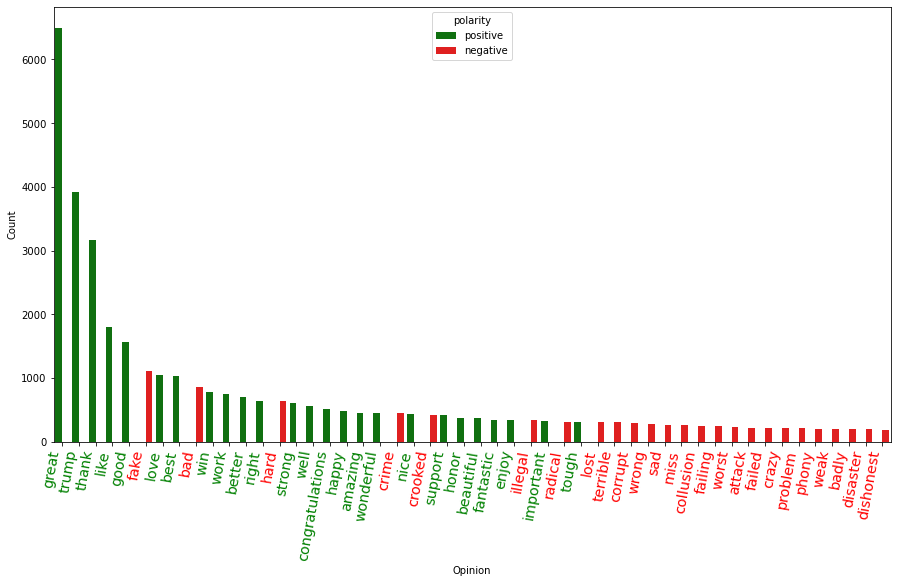

In [145]:
# call the plot_opinion function to plot tweets top positives and negatives words

plot_opinion(list_top_positives_opinion_ot, list_top_negatives_opinion_ot)

In [149]:
# compute the neutral/contextual words RDD by using rdd_original_tweets_words_lower, rdd_positive_words, rdd_negative_words and rdd_stop_words
# neutral words are words in product reviews file, that are not positive words or negative words or stop words
# tip: you can use the subtract transformation on RDD see documentation 
# http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD

contextual_words_ot = rdd_original_tweets_words_lower.subtract(rdd_positive_words).subtract(rdd_negative_words).subtract(rdd_stop_words)

contextual_words_ot.take(20)

['bahrain',
 'bahrain',
 'bahrain',
 'bahrain',
 'bahrain',
 'bahrain',
 'bahrain',
 'bahrain',
 '05:47:03',
 '05:03:00',
 '05:03:28',
 'let',
 'let',
 'let',
 'let',
 'let',
 'let',
 'let',
 'let',
 'let']

In [150]:
# use multiple transformations for counting each contextual word in the product review file, sorted in ascending order based 
# on the count

contextual_words_count_ordered_ot = contextual_words_ot.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_contextual_words_ot = contextual_words_count_ordered_ot.take(50)  

list_top_contextual_words_ot

[('just', 2858),
 ('people', 2597),
 ('president', 2222),
 ('new', 2072),
 ('big', 1749),
 ('make', 1657),
 ('america', 1563),
 ('country', 1546),
 ('time', 1410),
 ('obama', 1334),
 ('going', 1333),
 ('news', 1264),
 ('thanks', 1231),
 ('vote', 1199),
 ('want', 1195),
 ('democrats', 1099),
 ('need', 1053),
 ('run', 1028),
 ('u.s.', 1004),
 ('really', 1001),
 ('doing', 1001),
 ('think', 988),
 ('american', 978),
 ('job', 966),
 ('china', 885),
 ('today', 882),
 ('did', 872),
 ('know', 870),
 ('way', 844),
 ('said', 817),
 ("don't", 812),
 ('years', 812),
 ('media', 793),
 ('total', 777),
 ('hillary', 775),
 ('got', 748),
 ('jobs', 737),
 ('united', 728),
 ('look', 705),
 ('state', 694),
 ('day', 694),
 ('states', 693),
 ('border', 688),
 ('don’t', 670),
 ('deal', 634),
 ('house', 625),
 ('national', 625),
 ('world', 618),
 ('republican', 612),
 ('military', 610)]

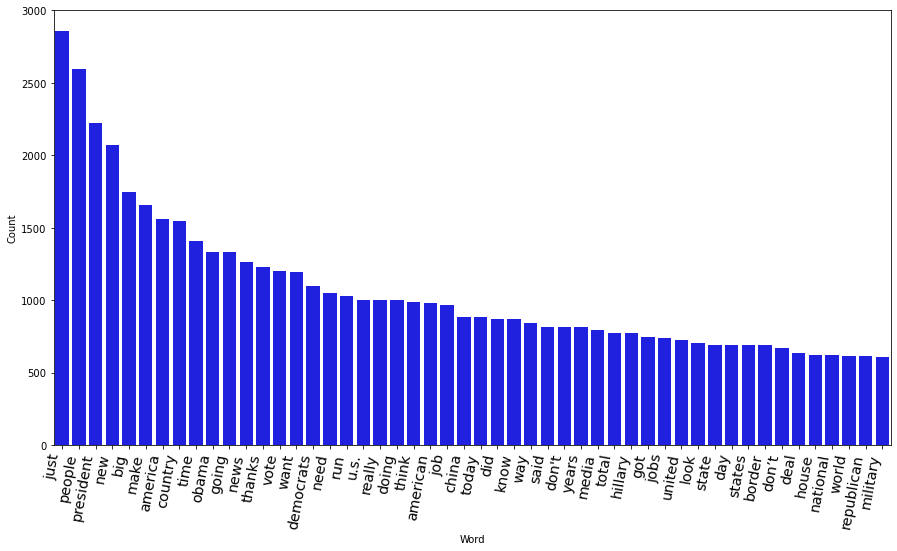

In [151]:
# call the plot_contextual_words function to plot tweets top contextual words

plot_contextual_words(list_top_contextual_words_ot)

In [153]:
# Compute the global sentiment score: the total count of positive words (e.g. use rdd_positive_words_ot_count_kv) minus
# the total count of negative words (e.g. use rdd_negative_words_ot_count_kv)


sentiment_score_ot = rdd_positive_words_ot_count_kv.map(lambda tuple: tuple[1]).sum()\
                  - rdd_negative_words_ot_count_kv.map(lambda tuple: tuple[1]).sum()

print('The sentiment score is : ',sentiment_score_ot)

The sentiment score is :  20854


In [154]:
### Analysis of retweets

# split each tweet into words
words_rt = rdd_retweets.flatMap(lambda line: line.split(" "))

# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags_rt = words_rt.filter(lambda w: '#' in w).map(lambda x: (x, 1))
hashtags_rt.take(10)

[('#MAGA🇺🇸🦅rally', 1),
 ('#Florida:', 1),
 ('#ProAmericaRally', 1),
 ('#AmyConeyBarrett', 1),
 ('#EarlyVoting', 1),
 ('#VOTE', 1),
 ('#Election2020', 1),
 ('#EarlyVoting', 1),
 ('#VoteEarly', 1),
 ('#…;16/10/2020', 1)]

In [155]:
hashtags_rt_count = hashtags_rt.reduceByKey(lambda x,y : x+y).sortBy(lambda tuple: tuple[1], ascending=False)
hashtags_rt_count.take(10)

[('#MAGA', 60),
 ('#COVID19', 38),
 ('#USMCA', 24),
 ('#coronavirus', 20),
 ('#PaycheckProtectionProgram', 18),
 ('#COVID19.', 17),
 ('#Dorian', 17),
 ('#impeachment', 16),
 ('#Trump2016', 13),
 ('#MakeAmericaGreatAgain', 13)]

In [156]:
# filter the words to get only references, then map each reference to be a pair of (reference,1)

references_rt = words_rt.filter(lambda w: '@' in w).map(lambda x: (x, 1))
references_rt.take(10)

[('@CBS_Herridge:', 1),
 ('@MZHemingway:', 1),
 ('@WhiteHouse:', 1),
 ('@realDonaldTrump', 1),
 ('@EricTrump:', 1),
 ('@GOPChairwoman:', 1),
 ('@TomFitton:', 1),
 ('@RealDonaldTrump', 1),
 ('@marklevinshow:', 1),
 ('@RealRLimbaugh:', 1)]

In [157]:
references_rt_count = references_rt.reduceByKey(lambda x,y : x+y).sortBy(lambda tuple: tuple[1], ascending=False)
references_rt_count.take(10)

[('@realDonaldTrump', 1142),
 ('@realDonaldTrump:', 1054),
 ('@WhiteHouse:', 657),
 ('@TeamTrump:', 276),
 ('@GOPChairwoman:', 212),
 ('@DanScavino:', 160),
 ('@Jim_Jordan:', 139),
 ('@GOP:', 138),
 ('@DonaldJTrumpJr:', 114),
 ('@Scavino45:', 114)]

In [158]:
# compute an rdd with individual words (rdd_retweets_words) from the rdd_product by using the previous function
# rdd_retweets_words should not contain empty strings

rdd_retweets_words = rdd_retweets.flatMap(split_with_multiple_separator).filter(lambda word: word!='')
rdd_retweets_words.take(10)



['RT',
 '@CBS_Herridge:',
 'READ:',
 'Letter',
 'to',
 'surveillance',
 'court',
 'obtained',
 'by',
 'CBS']

In [159]:
#Use the fucntion 'Func' created before to lower the case of each word 

rdd_retweets_words_lower = rdd_retweets_words.flatMap(Func)
rdd_retweets_words_lower.take(10)

['rt',
 '@cbs_herridge:',
 'read:',
 'letter',
 'to',
 'surveillance',
 'court',
 'obtained',
 'by',
 'cbs']

In [176]:
#delete "rt"

delword = ["rt"]
def delrt(line):
    for i in delword:
        if i in line:
            return 1
    return 0
rdd_retweets_words_lower = rdd_retweets_words_lower.filter(lambda line: delrt(line) != 1)
rdd_retweets_words_lower.take(10)

['@cbs_herridge:',
 'read:',
 'letter',
 'to',
 'surveillance',
 'obtained',
 'by',
 'cbs',
 'news',
 'questions']

In [160]:
# initialize an rdd with key/value for counting each word in the file 

rdd_retweets_words_kv = rdd_retweets_words_lower.map(lambda word: (word, 1))

rdd_retweets_words_kv.take(10)

[('rt', 1),
 ('@cbs_herridge:', 1),
 ('read:', 1),
 ('letter', 1),
 ('to', 1),
 ('surveillance', 1),
 ('court', 1),
 ('obtained', 1),
 ('by', 1),
 ('cbs', 1)]

In [161]:
# rdd_positive_words_rt_kv RDD should contain positive words in the product review file

rdd_positive_words_rt_kv = rdd_retweets_words_kv.join(rdd_positive_words_kv)

rdd_positive_words_rt_kv.take(5)

[('right', (1, 1)),
 ('right', (1, 1)),
 ('right', (1, 1)),
 ('right', (1, 1)),
 ('right', (1, 1))]

In [162]:
# use the mapValues transformation to assign a default count of 1 for each positive word

rdd_positive_words_rt_kv = rdd_positive_words_rt_kv.mapValues(lambda tuple: 1)

rdd_positive_words_rt_kv.take(5)

[('right', 1), ('right', 1), ('right', 1), ('right', 1), ('right', 1)]

In [163]:
# rdd_positive_words_rt_count_kv should contain the number of occurences (count) of each positive word in tweets

rdd_positive_words_rt_count_kv = rdd_positive_words_rt_kv.reduceByKey(lambda x,y : x+y)


rdd_positive_words_rt_count_kv.take(5)

[('right', 112), ('good', 108), ('like', 183), ('safe', 31), ('effective', 9)]

In [164]:
# rdd_positive_words_rt_count_kv_ordered should contain the previous RDD in descending order based on the count

rdd_positive_words_rt_count_kv_ordered = rdd_positive_words_rt_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_positives_opinion_rt = rdd_positive_words_rt_count_kv_ordered.take(25)

list_top_positives_opinion_rt

[('trump', 926),
 ('great', 397),
 ('thank', 272),
 ('like', 183),
 ('support', 152),
 ('right', 112),
 ('good', 108),
 ('work', 105),
 ('best', 103),
 ('strong', 83),
 ('love', 81),
 ('win', 80),
 ('protect', 73),
 ('incredible', 68),
 ('happy', 67),
 ('proud', 65),
 ('approval', 63),
 ('important', 63),
 ('honor', 59),
 ('supreme', 52),
 ('better', 52),
 ('congratulations', 49),
 ('clear', 49),
 ('well', 48),
 ('amazing', 47)]

In [165]:
# rdd_negative_words_rt_kv RDD should contain negative words in the tweets file

rdd_negative_words_rt_kv = rdd_retweets_words_kv.join(rdd_negative_words_kv)

rdd_negative_words_rt_kv.take(5)

[('dishonest', (1, 1)),
 ('dishonest', (1, 1)),
 ('dishonest', (1, 1)),
 ('dishonest', (1, 1)),
 ('dishonest', (1, 1))]

In [166]:
# use the mapValues transformation to assign a default count of 1 for each negative word

rdd_negative_words_rt_kv = rdd_negative_words_rt_kv.mapValues(lambda tuple:1)

rdd_negative_words_rt_kv.take(5)

[('dishonest', 1),
 ('dishonest', 1),
 ('dishonest', 1),
 ('dishonest', 1),
 ('dishonest', 1)]

In [167]:
# rdd_negative_words_rt_count_kv should contain the number of occurences (count) of each negative word in tweets

rdd_negative_words_rt_count_kv = rdd_negative_words_rt_kv.reduceByKey(lambda x,y: x+y)

rdd_negative_words_rt_count_kv.take(5)

[('dishonest', 7),
 ('lost', 32),
 ('fraud', 36),
 ('killed', 30),
 ('grieving', 2)]

In [168]:
# rdd_negative_words_rt_count_kv_ordered should contain the previous RDD in descending order based on the count

rdd_negative_words_rt_count_kv_ordered = rdd_negative_words_rt_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_negatives_opinion_rt = rdd_negative_words_rt_count_kv_ordered.take(25)

list_top_negatives_opinion_rt

[('fake', 93),
 ('radical', 65),
 ('hard', 57),
 ('collusion', 53),
 ('impeach', 51),
 ('illegal', 48),
 ('sham', 46),
 ('partisan', 45),
 ('critical', 45),
 ('breaking', 42),
 ('crime', 41),
 ('attack', 41),
 ('destroy', 40),
 ('bad', 40),
 ('abuse', 38),
 ('lies', 37),
 ('crisis', 37),
 ('fraud', 36),
 ('wrong', 36),
 ('hoax', 36),
 ('corrupt', 35),
 ('failed', 33),
 ('lost', 32),
 ('false', 32),
 ('criminal', 31)]

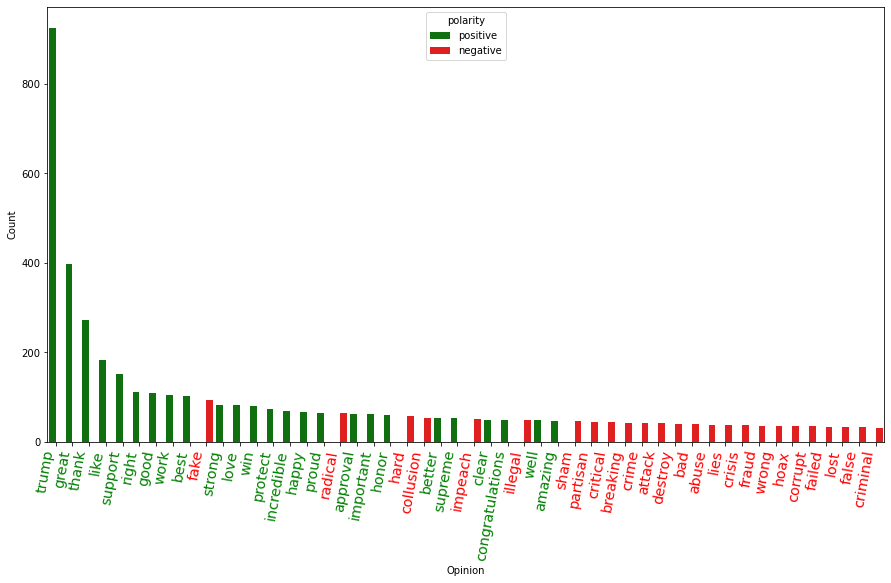

In [169]:
# call the plot_opinion function to plot tweets top positives and negatives words

plot_opinion(list_top_positives_opinion_rt, list_top_negatives_opinion_rt)

In [174]:
# compute the neutral/contextual words RDD by using rdd_retweets_words_lower, rdd_positive_words, rdd_negative_words and rdd_stop_words
# neutral words are words in product reviews file, that are not positive words or negative words or stop words
# tip: you can use the subtract transformation on RDD see documentation 
# http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD

contextual_words_rt = rdd_retweets_words_lower.subtract(rdd_positive_words).subtract(rdd_negative_words).subtract(rdd_stop_words)

contextual_words_rt.take(20)

['action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action',
 'action']

In [177]:
# use multiple transformations for counting each contextual word in the product review file, sorted in ascending order based 
# on the count

contextual_words_count_ordered_rt = contextual_words_rt.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_contextual_words_rt = contextual_words_count_ordered_rt.take(50)  

list_top_contextual_words_rt

[('president', 1397),
 ('@whitehouse:', 657),
 ('democrats', 469),
 ('american', 389),
 ('just', 381),
 ('biden', 365),
 ('new', 360),
 ('people', 356),
 ('impeachment', 323),
 ('"""rt', 308),
 ('today', 286),
 ('@teamtrump:', 276),
 ('joe', 267),
 ('house', 246),
 ('america', 245),
 ('news', 222),
 ('media', 220),
 ('@gopchairwoman:', 212),
 ('senate', 200),
 ('time', 187),
 ('fbi', 184),
 ('want', 180),
 ('coronavirus', 175),
 ('day', 174),
 ('vote', 174),
 ('years', 164),
 ('says', 161),
 ('obama', 161),
 ('@danscavino:', 160),
 ('did', 158),
 ('election', 155),
 ('americans', 155),
 ('it’s', 150),
 ('national', 148),
 ('make', 147),
 ('schiff', 147),
 ('state', 146),
 ('u.s.', 145),
 ('country', 144),
 ('going', 141),
 ('@jim_jordan:', 139),
 ('@gop:', 138),
 ('live:', 136),
 ('said', 134),
 ('big', 132),
 ('know', 129),
 ('united', 129),
 ('republican', 124),
 ('states', 123),
 ('help', 123)]

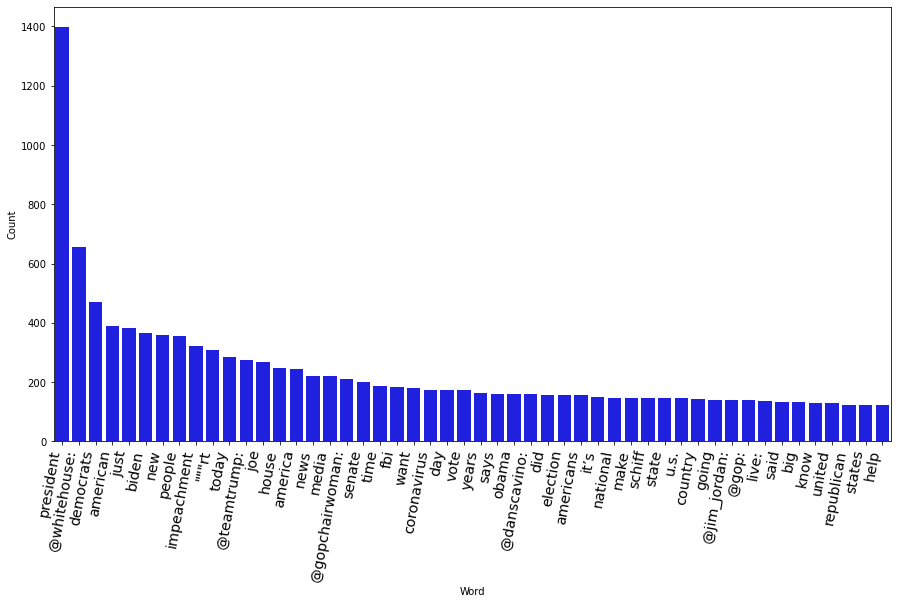

In [178]:
# call the plot_contextual_words function to plot tweets top contextual words

plot_contextual_words(list_top_contextual_words_rt)

In [179]:
# Compute the global sentiment score: the total count of positive words (e.g. use rdd_positive_words_rt_count_kv) minus
# the total count of negative words (e.g. use rdd_negative_words_rt_count_kv)


sentiment_score_rt = rdd_positive_words_rt_count_kv.map(lambda tuple: tuple[1]).sum()\
                  - rdd_negative_words_rt_count_kv.map(lambda tuple: tuple[1]).sum()

print('The sentiment score is : ',sentiment_score_rt)

The sentiment score is :  1826
